# Testing Snake creation and evolution
Much (but not all) of this code will be duplicated to [main.py](../main.py)

In [1]:
### Imports ###
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

import tsnake.initialize as init
from tsnake.snake import TSnake, Element, Node
from tsnake.grid import Grid, Point
from tsnake.utils import dist, seg_intersect

## Load images, compute masked reigons

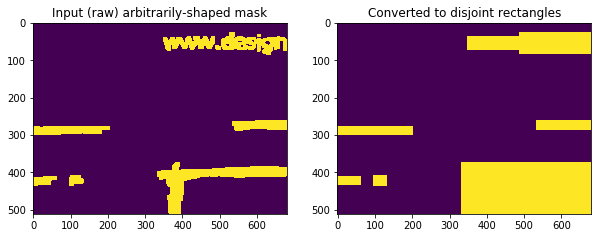

In [2]:
msk_path = '../examples/places2/case1_mask.png'
img_path = '../examples/places2/case1_raw.png'
mask = init.load_mask(msk_path)
image = init.load_grayscale_image(img_path)

regions = init._find_disjoint_masked_regions(mask)

# NOTE: Uncomment to visialize initial masked reigons
init.visualize_masked_regions(mask, regions)

regions = init.compute_masked_regions(image, mask)

## Initialize t-snakes
_Note: Length 17 t-snake (i.e. the sort one) is visibly wrong, not sure how we can fix that_
*Legend*
* Green lines: Normal vectors
* White Nodes: Initial 5 nodes of the snake
* Yellow Nodes: Final 5 nodes of the snake
    * This tells us which way the snake was initialized, Counter Clockwise or Clockwise

In [3]:
tsnakes = []

### Parameters for TSnakes ### 
sigma = 20.0  # gaussian filter sigma
p = 1.0       # scale final image force with p
c = 2.0       # scale gradient magnitude of image (applied before p)
a = 1.0       # tension parameter
b = 1.0       # bending parameter
gamma = 1.0   # friction coefficient
dt = 1.0      # time step

for region in regions:
    tsnake = region.initialize_tsnake(
        N=1000, p=p, c=c, sigma=sigma, a=a, b=b, gamma=gamma,
        dt=dt
    )
    tsnakes.append(tsnake)
#     region.visualize() # NOTE: To show tsnakes on images, uncomment

# tsnakes.sort(key=lambda t: len(t.nodes))
# print("Length of T-Snakes initialized on image (sorted):\n{}".format(
#     [len(t.nodes) for t in tsnakes]))

## Create Grid and add Snakes to it

In [4]:
image = init.load_grayscale_image(img_path)
print(image.shape)
grid = Grid(image=image, scale=4)

# Update grid
# NOTE: Uncomment for force, expensive calculation
force = grid.get_image_force(2,2,2)
grid.gen_simplex_grid()
print("Simplex Grid shape: {}".format(grid.grid.shape))

# Add snakes to grid
for s in tsnakes:
    grid.add_snake(s)
    break

(512, 680)
Simplex Grid shape: (128, 170)


## Test Intersection Computation

In [5]:
# Compute snake intersections with grid
intersections = grid.get_snake_intersections()
# print(intersections)


[[(7.0, 8.0), (7.0, 9.0), (7.0, 8.0), (7.0, 5.0), (7.0, 4.0), (7.0, 5.0), (7.0, 4.0), (7.0, 1.0), (7.0, 0.0), (7.0, 1.0), (7.0, 0.0), (6.875, 1.125), (6.556, 4.0), (6.375, 5.625), (4.0, 9.0), (3.0, 9.0), (4.0, 9.0), (3.0, 9.0), (-0.0, 9.0), (7.0, 9.0), (-0.0, 9.0), (4.0, 9.0), (3.0, 9.0)]]


## Test snake evolution

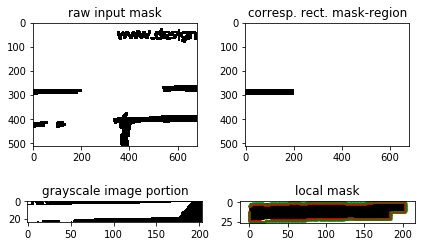

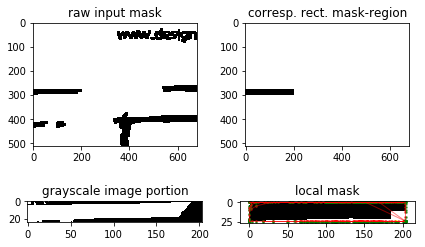

In [6]:
# Before:

regions[-1].visualize()
# Test snake evolution
M = 20 # number of m-steps (iterations)

# Pick one of the snakes on the grid, they are sorted by size
snake = tsnakes[-1] 

# X and Y are matrices to save the position of the 
# snake for every iteration
X = np.zeros((snake.num_nodes,M+1))
Y = np.zeros((snake.num_nodes,M+1))

# save the initial position of the snake
for i in tqdm(range(snake.num_nodes)):
    pos = snake.nodes[i].position
    X[i][0] = pos[0][0]
    Y[i][0]= pos[0][1]

# run for M steps
for j in tqdm(range(M)):
    #print(out[200,:,0])
    snake.m_step(1) # FIXME: This won't work until TODOs from snake.py line 340 are addressed

    #save the updated positions of the nodes
    for i in range(snake.num_nodes):
        pos = snake.nodes[i].position
        #print(pos)
        X[i, j+1] = pos[0,0]
        Y[i, j+1]= pos[0,1]

regions[-1].visualize()

## Visualize Evolution

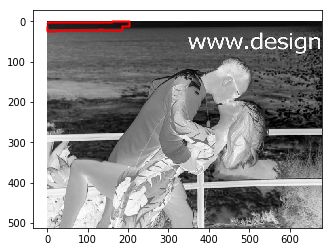

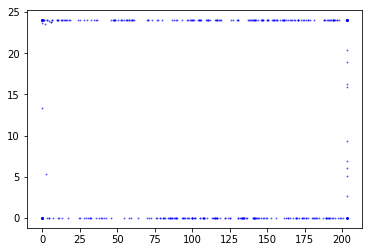

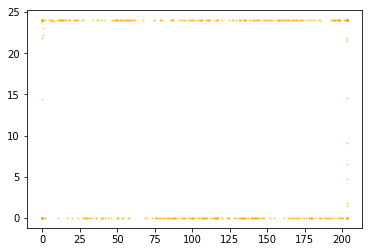

In [7]:
### TODO ###
plt.imshow(image, cmap=plt.cm.binary)
colors = ['red', 'blue', 'orange', 'green','black']
for i in range(3):
    plt.scatter(Y[:,i], X[:,i], c=colors[i], s=1, alpha=0.5)
    plt.show()